### National Meeting of Data-Intensive Science CDTs
**University of Edinburgh, 21 November 2018**

# Neural Networks in TensorFlow   
  
### Steven Bamford
**University of Nottingham**

### Setting up your environment

You can create a suitable conda environment to run this notebook using:

    conda create -n keras_demo python=3 tensorflow matplotlib ipykernel scikit-learn pandas
    
If you have a GPU haven't got the latest cuda drivers, you may also need to specify `cudatoolkit=9.0` or similar.

### Some common imports and setup

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# bigger fonts
plt.rcParams['font.size'] = 18

## Deep learning with neural networks

<img src="https://upload.wikimedia.org/wikipedia/commons/0/0a/Anatomy_of_a_Neuron_with_Synapse.png" alt="Biological neuron" width="75%" />

<img src="https://upload.wikimedia.org/wikipedia/commons/6/60/ArtificialNeuronModel_english.png" alt="Neuron model" width="85%" />

#### Activation functions

Introduce non-linearity, critical to performance of neural networks.

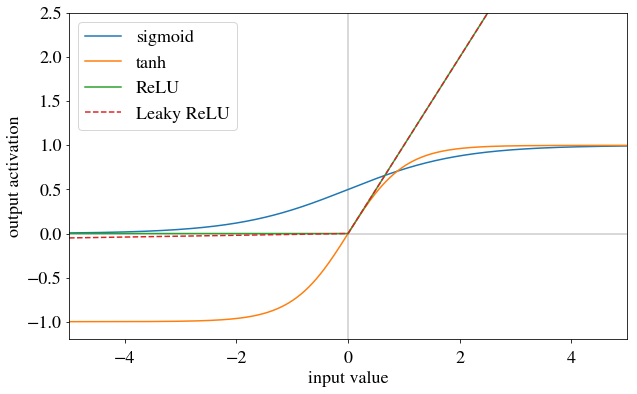

In [3]:
z = np.linspace(-5, 5, 1000)
plt.subplots(figsize=(10, 6))
plt.hlines(0, -5, 5, alpha=0.2)
plt.vlines(0, -1.2, 2.5, alpha=0.2)
plt.plot(z, 1 / (1 + np.exp(-z)), label='sigmoid')
plt.plot(z, np.tanh(z), label='tanh')
plt.plot(z, np.maximum(0, z), label='ReLU')
plt.plot(z, np.maximum(0.01 * z, z), ls='--', label='Leaky ReLU')
plt.axis([-5, 5, -1.2, 2.5])
plt.xlabel('input value')
plt.ylabel('output activation')
plt.legend();

#### Feed-forward networks: stack layers of neurons, with unidirectional connections between layers

<img src="http://neuralnetworksanddeeplearning.com/images/tikz36.png" alt="Deep ANN" width="60%" />

## Supervised learning

* Large quantity of input training data with known labels
* Train network (adjust weights) such that training inputs result in outputs that match the labels
* Validate by inputing (labelled) test data and checking outputs match labels
* Apply network to new (unlabelled) data to produce estimated labels

#### Cost/Loss function

Various options, but typically:
* For regression: **mean squared error**
  * $\frac{1}{N} \sum_{i=1}^N{(y - \hat{y})^2}$, where $y$ is the prediction and $\hat{y}$ is the true value.
* For classification: **categorical cross entropy**
  * $\sum_i q_i \log(p_i)$, where $p_i$ is the output probability of the input corresponding to class $i$, and $q_i = 1$ if $i$ is the correct class and $0$ otherwise.

#### Other performance measures

* Accuracy
* Error rate
* Precision
* Recall
* TP/FP/TN/FN
* etc...

#### Stochastic gradient descent

* Update weights to reduce the loss
* Based on gradient of the loss function wrt each weight
* Estimated using mini-batches of the input data
* Multiplied by a **learning rate**

#### Refinements:

* Adaptive learning rate
* Momentum

#### Backpropagation

* Efficient algorithm to calculate all the gradients
* Perform forward pass and save results for each neuron
* Then pass backward through the network propagating gradients using chain rule
* Results in gradient of the loss function with respect to each weight

### Detailed backpropagation algorithm

#### 1. Input

$x$: Set the corresponding activations, $a^1$, for the input layer.

#### 2. Feedforward

For each layer, $l = 2, 3, \dots, L$, compute weighted sum of input activations from previous layer (plus a bias) $z^l = w^l a^{l-1} + b^l$ and resulting output activations $a^l = \sigma(z^l)$.

#### 3. Output, loss and output error

The output of the network is $a^L$, with loss $C(a^L, y)$, where $y$ are the labels corresponding to $x$.

The error on each $z^L$ is $\delta^L = \nabla_a C \odot \sigma^\prime(z^L)$, where $\nabla_a C$ is the partial derivative of $C$ with respect to $a^L$, $\odot$ is the elementwise (Hadamard) product and $\sigma^\prime(z^L)$ is the derivative of the activation function evaluated at $z^L$.

#### 4. Backpropagate the error

For each layer, $l = L-1, L-2, \dots, 2$ compute the error on the $z^l$ as $\delta^L = \left((w^{l+1})^\textrm{T} \delta^{l+1}\right) \odot \sigma^\prime(z^l)$.

#### 5. Gradients

The gradient of the cost function with respect to the network parameters is given by $\displaystyle\frac{\partial C}{\partial w^l_{jk}} = a^{l-1}_k \delta^l_j$ and $\displaystyle\frac{\partial C}{\partial b^l_{j}} = \delta^l_j$.

#### 6. Update weights

Update the weights using $w^l \rightarrow w^l - \eta \displaystyle\frac{\partial C}{\partial w^l}$ and biases $b^l \rightarrow b^l - \eta \displaystyle\frac{\partial C}{\partial b^l}$, where $\eta$ is the learning rate. 

## Training simple neural networks on the MNIST dataset using keras

### Set up TensorFlow in a friendly manner

In [4]:
import tensorflow as tf

# if multiple GPUs, only use one of them 
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# avoid hogging all the GPU memory
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [5]:
# check that we have the devices we expect available
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1637908161404125228]

### Import keras bits and pieces

In [6]:
# if you have a recent version of tensorflow, keras is included
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop

### We will use a standard demonstration data set: MNIST handwritten digits

![MNIST](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png "MNIST")


### Load the data

In [7]:
# the data, split between train and test sets
(x_train, y_train), (x_valtest, y_valtest) = mnist.load_data()

### Some experimental variations

In [8]:
# demo the effect of noisy data...
#x_train = (x_train/5 +
#           np.random.poisson(200, size=x_train.shape)).clip(0, 255)
#x_valtest = (x_valtest/5 +
#             np.random.poisson(200, size=x_valtest.shape)).clip(0, 255)

In [9]:
# reduce the amount of training data...
idx = np.random.choice(len(x_train), size=len(x_train)//100)
x_train = x_train[idx]
y_train = y_train[idx]

If your data isn't split, or want a validation set, need to do the split manually

We will split the test data set so we have an independent data set for additional validation

In [10]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_valtest, y_valtest,
                                                test_size=0.5)

In [11]:
x_train.shape, y_train.shape

((600, 28, 28), (600,))

In [12]:
x_test.shape, y_test.shape, x_val.shape, y_val.shape

((5000, 28, 28), (5000,), (5000, 28, 28), (5000,))

### Take a look at the data

This is a very quick glance - you should carefully examine any new dataset

class = 0


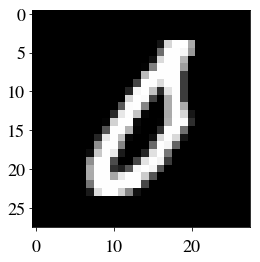

In [13]:
i = 29
plt.imshow(x_train[i], cmap='gray')
print('class =', y_train[i])

### Prepare the data

In [14]:
# convert class vectors to "one-hot" binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [15]:
y_train[i]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [16]:
def process_data(x):
    x = x.reshape(-1, 784)
    x = x.astype('float32')
    x /= 255
    return x

In [17]:
x_train = process_data(x_train)
x_test = process_data(x_test)

## Fully-connected NN

### Construct the network

In [18]:
# a fairly small network
fcmodel = Sequential()
fcmodel.add(Dense(32, activation='relu', input_shape=(784,)))
# could include dropout, regularisation, ...
#fcmodel.add(Dropout(0.5))
fcmodel.add(Dense(32, activation='relu'))
fcmodel.add(Dense(num_classes, activation='softmax'))

In [19]:
fcmodel.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])

In [20]:
fcmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


#### Softmax activation function

Produces probabilities over a set of classes – usual choice for last layer of classification network

$$a_j = \sigma(z_j) = \frac{\exp(z_j)}{\sum_k \exp(z_k)}$$

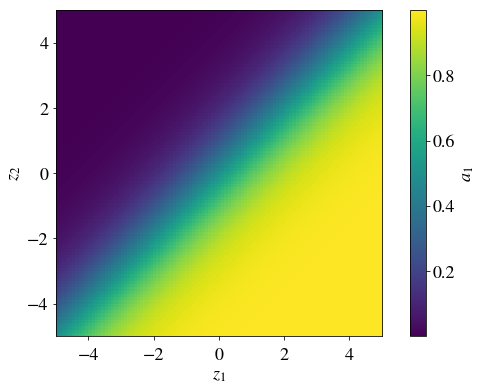

In [21]:
z1, z2 = (np.indices((101, 101)) / 100 - 0.5) * 10
a = np.exp(z1) / (np.exp(z1) + np.exp(z2))
plt.subplots(figsize=(10, 6))
plt.imshow(a.T, extent=(-5, 5, -5, 5), origin='lower')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
ax = plt.colorbar()
ax.set_label('$a_1$');

### Train the network

In [22]:
batch_size = 32
epochs = 50

In [23]:
history = fcmodel.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=2,
                      validation_data=(x_test, y_test))

Train on 600 samples, validate on 5000 samples
Epoch 1/50
 - 2s - loss: 1.9630 - acc: 0.3717 - val_loss: 1.6304 - val_acc: 0.5966
Epoch 2/50
 - 0s - loss: 1.3733 - acc: 0.6850 - val_loss: 1.2299 - val_acc: 0.6820
Epoch 3/50
 - 0s - loss: 0.9950 - acc: 0.7533 - val_loss: 0.9530 - val_acc: 0.7544
Epoch 4/50
 - 0s - loss: 0.7680 - acc: 0.8167 - val_loss: 0.8006 - val_acc: 0.7778
Epoch 5/50
 - 0s - loss: 0.6077 - acc: 0.8617 - val_loss: 0.7037 - val_acc: 0.8032
Epoch 6/50
 - 0s - loss: 0.4987 - acc: 0.8817 - val_loss: 0.6249 - val_acc: 0.8296
Epoch 7/50
 - 0s - loss: 0.4121 - acc: 0.9117 - val_loss: 0.5961 - val_acc: 0.8318
Epoch 8/50
 - 0s - loss: 0.3413 - acc: 0.9150 - val_loss: 0.5644 - val_acc: 0.8312
Epoch 9/50
 - 0s - loss: 0.2966 - acc: 0.9267 - val_loss: 0.5325 - val_acc: 0.8394
Epoch 10/50
 - 0s - loss: 0.2485 - acc: 0.9433 - val_loss: 0.5258 - val_acc: 0.8448
Epoch 11/50
 - 0s - loss: 0.2188 - acc: 0.9550 - val_loss: 0.4970 - val_acc: 0.8528
Epoch 12/50
 - 0s - loss: 0.1825 - acc

In [24]:
score = fcmodel.evaluate(x_test, y_test, verbose=0)
print('Test loss: {:.3f}'.format(score[0]))
print('Test accuracy: {:.3f}'.format(score[1]))

Test loss: 0.907
Test accuracy: 0.856


In [25]:
def histplot(history):
    hist = pd.DataFrame(history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    hist.plot(y=['loss', 'val_loss'], ax=ax1)
    min_loss = hist['val_loss'].min()
    ax1.hlines(min_loss, 0, len(hist), linestyle='dotted',
               label='min(val_loss) = {:.3f}'.format(min_loss))
    ax1.legend(loc='upper right', fontsize='large')
    hist.plot(y=['acc', 'val_acc'], ax=ax2)
    max_acc = hist['val_acc'].max()
    ax2.hlines(max_acc, 0, len(hist), linestyle='dotted',
               label='max(val_acc) = {:.3f}'.format(max_acc))
    ax2.legend(loc='lower right', fontsize='large')

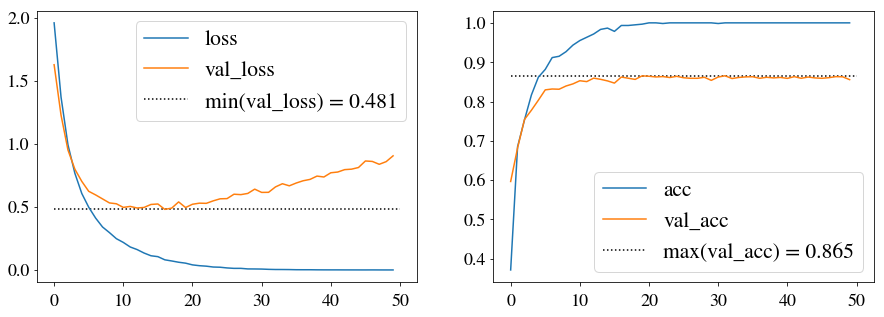

In [26]:
histplot(history)

Note over-fitting!

Over-fitting common, not always a problem.

Suggests potential for an approach with fewer parameters or regularisation, and hence better generalisation.

Note that could have stopped training when the validation loss plateaued: *early stopping* approach to avoiding over-fitting.

Training a fully-connected network with many layers is challenging. Consider alternative architectures which exploit key properties of the data.

## Convolutional Neural Network (CNN)

<br/>
<br/>

<img src="https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png" alt="CNN" width="80%" />


#### Convolution

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4f/3D_Convolution_Animation.gif" width="50%" />

#### Pooling

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png" width="30%" />

### Reshape the data

In [27]:
# Turn back into stacks of 2D images
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

### Construct the network

In [28]:
# a fairly small network for speed
cnnmodel = Sequential()
cnnmodel.add(Conv2D(8, (3, 3), activation='relu', input_shape=(28, 28, 1)))
cnnmodel.add(MaxPooling2D((3, 3)))
cnnmodel.add(Conv2D(16, (3, 3), activation='relu'))
cnnmodel.add(MaxPooling2D((2, 2)))
# could include dropout, regularisation, ...
#cnnmodel.add(Dropout(0.5))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(num_classes, activation='softmax'))

In [29]:
cnnmodel.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])

In [30]:
cnnmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 16)          1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 144)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1450      
Total params: 2,698
Trainable params: 2,698
Non-trainable params: 0
_________________________________________________________________


In [31]:
# save weights for reinitialising below
cnnmodel.save_weights('/tmp/cnnmodel_init_weights.tf')


Consider using a TensorFlow optimizer from `tf.train`.


### Train the network

In [32]:
history = cnnmodel.fit(x_train, y_train,
                       batch_size=batch_size, 
                       epochs=3*epochs,
                       verbose=2,
                       validation_data=(x_test, y_test))

Train on 600 samples, validate on 5000 samples
Epoch 1/150
 - 1s - loss: 2.2651 - acc: 0.1383 - val_loss: 2.2257 - val_acc: 0.2062
Epoch 2/150
 - 0s - loss: 2.1638 - acc: 0.3417 - val_loss: 2.1240 - val_acc: 0.3316
Epoch 3/150
 - 0s - loss: 2.0328 - acc: 0.4567 - val_loss: 1.9739 - val_acc: 0.5494
Epoch 4/150
 - 0s - loss: 1.8471 - acc: 0.5900 - val_loss: 1.7661 - val_acc: 0.6450
Epoch 5/150
 - 0s - loss: 1.6116 - acc: 0.7117 - val_loss: 1.5125 - val_acc: 0.6788
Epoch 6/150
 - 0s - loss: 1.3585 - acc: 0.7350 - val_loss: 1.2664 - val_acc: 0.7426
Epoch 7/150
 - 0s - loss: 1.1289 - acc: 0.7800 - val_loss: 1.0479 - val_acc: 0.7876
Epoch 8/150
 - 0s - loss: 0.9357 - acc: 0.8050 - val_loss: 0.8939 - val_acc: 0.7888
Epoch 9/150
 - 0s - loss: 0.7964 - acc: 0.8233 - val_loss: 0.7624 - val_acc: 0.8236
Epoch 10/150
 - 0s - loss: 0.6822 - acc: 0.8417 - val_loss: 0.6747 - val_acc: 0.8280
Epoch 11/150
 - 0s - loss: 0.5920 - acc: 0.8450 - val_loss: 0.6122 - val_acc: 0.8326
Epoch 12/150
 - 0s - loss: 

Epoch 97/150
 - 1s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.3496 - val_acc: 0.9288
Epoch 98/150
 - 0s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.3702 - val_acc: 0.9250
Epoch 99/150
 - 0s - loss: 8.5134e-04 - acc: 1.0000 - val_loss: 0.3626 - val_acc: 0.9274
Epoch 100/150
 - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.3725 - val_acc: 0.9248
Epoch 101/150
 - 0s - loss: 8.0825e-04 - acc: 1.0000 - val_loss: 0.3682 - val_acc: 0.9266
Epoch 102/150
 - 0s - loss: 7.3114e-04 - acc: 1.0000 - val_loss: 0.4134 - val_acc: 0.9190
Epoch 103/150
 - 0s - loss: 6.7613e-04 - acc: 1.0000 - val_loss: 0.3781 - val_acc: 0.9238
Epoch 104/150
 - 0s - loss: 7.1971e-04 - acc: 1.0000 - val_loss: 0.3768 - val_acc: 0.9284
Epoch 105/150
 - 0s - loss: 5.4548e-04 - acc: 1.0000 - val_loss: 0.4052 - val_acc: 0.9236
Epoch 106/150
 - 0s - loss: 6.7434e-04 - acc: 1.0000 - val_loss: 0.3921 - val_acc: 0.9290
Epoch 107/150
 - 0s - loss: 4.2115e-04 - acc: 1.0000 - val_loss: 0.4030 - val_acc: 0.9254
Epoch 108/150
 - 0s - los

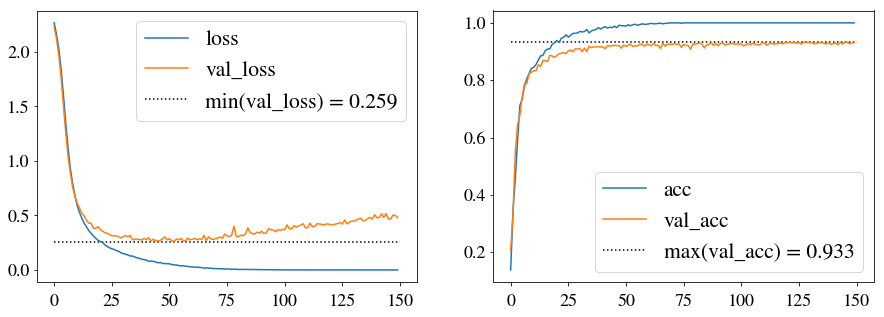

In [33]:
histplot(history)

### Evaluate models

In [34]:
x_val_1d = process_data(x_val)
x_val_2d = x_val_1d.reshape(-1, 28, 28, 1)
fcscore = fcmodel.evaluate(x_val_1d, y_val, verbose=0)
cnnscore = cnnmodel.evaluate(x_val_2d, y_val, verbose=0)
print('FC:   loss: {:.3f},  accuracy: {:.3f}'.format(*fcscore))
print('CNN:  loss: {:.3f},  accuracy: {:.3f}'.format(*cnnscore))

FC:   loss: 0.794,  accuracy: 0.864
CNN:  loss: 0.388,  accuracy: 0.937


## Online data augmentation

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=20.0,
    zoom_range=0.05)

#datagen.fit(x_train)  # only required if normalizing

In [36]:
gen = datagen.flow(x_train, y_train, batch_size=1)

label = 8


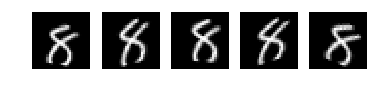

In [37]:
# run this several times to see more augmented examples
i = 1
fig, axarr = plt.subplots(1, 5)
for ax in axarr:
    img = gen[i][0][0, : , :, 0]
    ax.imshow(img, cmap='gray');
    ax.axis('off')
print('label =', gen[i][1][0].argmax())

In [38]:
# Reinitialise model
cnnmodel.load_weights('/tmp/cnnmodel_init_weights.tf')

In [39]:
cnnmodel.compile(loss='categorical_crossentropy',
                 optimizer=RMSprop(),
                 metrics=['accuracy'])

In [40]:
# fits the model on batches with real-time data augmentation:
# the accuracy continues to (slowly) rise, due to the augmentation
history = cnnmodel.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                                 epochs=5*epochs,
                                 verbose=2,
                                 validation_data=(x_test, y_test))

Epoch 1/250
 - 2s - loss: 2.2779 - acc: 0.1283 - val_loss: 2.2401 - val_acc: 0.1582
Epoch 2/250
 - 1s - loss: 2.2156 - acc: 0.2566 - val_loss: 2.1676 - val_acc: 0.2716
Epoch 3/250
 - 1s - loss: 2.1444 - acc: 0.3163 - val_loss: 2.0583 - val_acc: 0.4064
Epoch 4/250
 - 1s - loss: 2.0305 - acc: 0.4418 - val_loss: 1.9017 - val_acc: 0.5560
Epoch 5/250
 - 1s - loss: 1.9040 - acc: 0.5269 - val_loss: 1.6961 - val_acc: 0.6678
Epoch 6/250
 - 1s - loss: 1.6952 - acc: 0.6316 - val_loss: 1.4710 - val_acc: 0.7118
Epoch 7/250
 - 0s - loss: 1.4980 - acc: 0.6694 - val_loss: 1.2526 - val_acc: 0.7118
Epoch 8/250
 - 0s - loss: 1.3323 - acc: 0.6687 - val_loss: 1.0445 - val_acc: 0.7738
Epoch 9/250
 - 0s - loss: 1.1925 - acc: 0.6810 - val_loss: 0.8913 - val_acc: 0.7946
Epoch 10/250
 - 0s - loss: 1.0527 - acc: 0.7264 - val_loss: 0.7744 - val_acc: 0.8146
Epoch 11/250
 - 1s - loss: 0.9477 - acc: 0.7368 - val_loss: 0.6923 - val_acc: 0.8244
Epoch 12/250
 - 1s - loss: 0.9099 - acc: 0.7314 - val_loss: 0.6308 - val_a

Epoch 98/250
 - 1s - loss: 0.1674 - acc: 0.9485 - val_loss: 0.1570 - val_acc: 0.9512
Epoch 99/250
 - 1s - loss: 0.1637 - acc: 0.9496 - val_loss: 0.1777 - val_acc: 0.9432
Epoch 100/250
 - 0s - loss: 0.1407 - acc: 0.9556 - val_loss: 0.1489 - val_acc: 0.9552
Epoch 101/250
 - 1s - loss: 0.1674 - acc: 0.9485 - val_loss: 0.1524 - val_acc: 0.9520
Epoch 102/250
 - 0s - loss: 0.1740 - acc: 0.9424 - val_loss: 0.1576 - val_acc: 0.9510
Epoch 103/250
 - 0s - loss: 0.1537 - acc: 0.9490 - val_loss: 0.1473 - val_acc: 0.9542
Epoch 104/250
 - 0s - loss: 0.1696 - acc: 0.9452 - val_loss: 0.1525 - val_acc: 0.9508
Epoch 105/250
 - 0s - loss: 0.1575 - acc: 0.9463 - val_loss: 0.1481 - val_acc: 0.9550
Epoch 106/250
 - 1s - loss: 0.1508 - acc: 0.9595 - val_loss: 0.1499 - val_acc: 0.9516
Epoch 107/250
 - 1s - loss: 0.1551 - acc: 0.9534 - val_loss: 0.1671 - val_acc: 0.9470
Epoch 108/250
 - 0s - loss: 0.1654 - acc: 0.9485 - val_loss: 0.1485 - val_acc: 0.9544
Epoch 109/250
 - 0s - loss: 0.1669 - acc: 0.9457 - val_l

Epoch 194/250
 - 0s - loss: 0.0771 - acc: 0.9699 - val_loss: 0.1445 - val_acc: 0.9554
Epoch 195/250
 - 0s - loss: 0.1038 - acc: 0.9633 - val_loss: 0.1301 - val_acc: 0.9604
Epoch 196/250
 - 0s - loss: 0.0967 - acc: 0.9720 - val_loss: 0.1366 - val_acc: 0.9586
Epoch 197/250
 - 0s - loss: 0.1010 - acc: 0.9639 - val_loss: 0.1409 - val_acc: 0.9574
Epoch 198/250
 - 0s - loss: 0.0816 - acc: 0.9687 - val_loss: 0.1316 - val_acc: 0.9598
Epoch 199/250
 - 0s - loss: 0.0896 - acc: 0.9687 - val_loss: 0.1505 - val_acc: 0.9556
Epoch 200/250
 - 0s - loss: 0.1107 - acc: 0.9616 - val_loss: 0.1361 - val_acc: 0.9592
Epoch 201/250
 - 1s - loss: 0.0782 - acc: 0.9731 - val_loss: 0.1335 - val_acc: 0.9596
Epoch 202/250
 - 0s - loss: 0.0759 - acc: 0.9759 - val_loss: 0.1377 - val_acc: 0.9596
Epoch 203/250
 - 0s - loss: 0.0863 - acc: 0.9770 - val_loss: 0.1392 - val_acc: 0.9580
Epoch 204/250
 - 0s - loss: 0.0892 - acc: 0.9666 - val_loss: 0.1468 - val_acc: 0.9566
Epoch 205/250
 - 0s - loss: 0.1119 - acc: 0.9628 - val

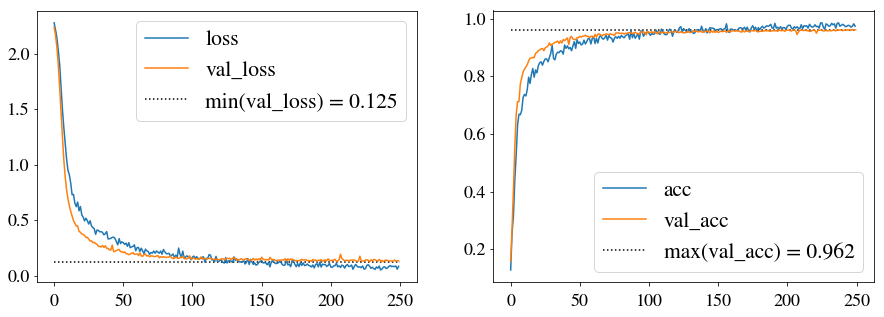

In [41]:
histplot(history)

Data augmentation reduced number of misclassifications by half.

### Any questions?